In [1]:
import torch.nn as nn
import torch.nn.parallel
import random
import argparse
# from network.resnet import resnet18, resnet34
# from network.pointnet import PointNetCls
from torch.utils.data import DataLoader
import os
import numpy as np
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
# from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from matplotlib import pyplot as plt, font_manager as fm

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

import nb_conda_kernels as kernels

In [2]:
bs = 256

In [4]:
torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 3*bs
np.random.seed(1)
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True)

mnist_dl = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn = lambda id: np.random.seed(0))

transform = transforms.Compose(
    [transforms.ToTensor()])

torch.manual_seed(0)
batch_size = bs
np.random.seed(1)
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
emnist_dataset = torchvision.datasets.EMNIST(root=image_path, train=True, transform=transform, split = 'letters', download=True)

emnist_dl = torch.utils.data.DataLoader(emnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn = lambda id: np.random.seed(0))


In [5]:
Z1, y1 =iter(mnist_dl).next()
Z2, y2 = iter(emnist_dl).next()

annot_y1 = torch.ones_like(y1)
annot_y2 = torch.zeros_like(y2)

Data1 = Z1.squeeze()
Data2 = Z2.squeeze()
X = Data1[0:2*bs]
Y = torch.vstack((Data1[2*bs:],torch.moveaxis(Data2,1,2)))

annot_X = annot_y1[0:2*bs]
annot_Y = torch.concat((annot_y1[2*bs:], annot_y2))

X_vec = X.reshape([X.shape[0],-1])
Y_vec = Y.reshape([Y.shape[0],-1])

In [8]:
gamma = 1
C = torch.norm(X_vec.unsqueeze(1) - Y_vec, dim=2).numpy()
M = C/np.max(C)
K = np.exp(-M/gamma)

cs = [1, 1.25, 1.5, 1.75, 2, 4, 8, 16, 20, 24, 28, 32]
# cs = [1, 1.25]
mu = np.ones(X.shape[0])/X.shape[0]
nu = np.ones(Y.shape[0])/Y.shape[0]
max_iter = 5000

largest_k = 10
smallest_k = 10

Weights_top_10 = np.zeros([len(cs), largest_k])
weights_bottom_10 = np.zeros([len(cs), largest_k])

fig, axs = plt.subplots(len(cs), largest_k, figsize=(8.45, 10))
# fig1.subplots_adjust(left=0.5, bottom=0.5, right=1.1, top=1.2)
fig.subplots_adjust(wspace=0, hspace=0)

fig1, axs1 = plt.subplots(len(cs), largest_k, figsize=(8.45, 10))
# fig1.subplots_adjust(left=0.5, bottom=0.5, right=1.1, top=1.2)
fig1.subplots_adjust(wspace=0, hspace=0)

y_idx_list = list(range(0, Y.shape[0]))
y_idx_sorted_lst_c = []
nu_idx_sorted_lst_c = []
annot_Y_sorted_lst_c = []

for l in range(0, len(cs)):
    c = cs[l]
    print("c=", c)

    objs, P, alpha, beta = ss_ipot(X_vec,Y_vec, mu, nu, c,  gamma, max_outer_iter=250, max_inner_iter = 20 , wd = 2, disp_iter = False, return_map=True)
    nu_hat = np.sum(P, axis=0)
    plt.plot(objs)

    zipped_sorted_nu_idx = sorted(zip(nu_hat, y_idx_list), reverse=True)

    nu_sorted, idx_sorted = list(zip(*zipped_sorted_nu_idx))
    y_idx_sorted_lst_c.append(list(idx_sorted))
    nu_idx_sorted_lst_c.append(list(nu_sorted))
    annot_Y_sorted = annot_Y[list(idx_sorted)]
    annot_Y_sorted_lst_c.append(annot_Y_sorted)

    nu_idx_sorted_10 = list(nu_sorted)[0:largest_k]
    nu_idx_sorted_desc = list(nu_sorted)[-largest_k:]

    Z = Y[list(idx_sorted)[0:largest_k]]
    Z1 = Y[list(idx_sorted)[-largest_k:]]
    annot_Z = annot_Y_sorted[0:largest_k]
    annot_Z1 = annot_Y_sorted[-largest_k:]

    nu_idx_sorted_10 = list(nu_sorted)[0:largest_k]
    nu_idx_sorted_desc = list(nu_sorted)[-smallest_k:]

    # Z = x_test[list(idx_sorted)[0:largest_k]]
    # Z1 = x_test[list(idx_sorted)[-largest_k:]]

    for k in range(0, len(Z)):
        if k == 0:
            axs[l, k].imshow(np.squeeze(Z[k]), cmap='Greys')
            axs[l, k].set_xticks([])
            axs[l, k].set_yticks([])
            axs[l, k].set_aspect('equal')
            ylabel_str = "c={0}".format(c)
            axs[l, k].set_ylabel(ylabel_str,  rotation='horizontal', ha='right', fontsize=20)
            axs[l, k].set_box_aspect(1)

            axs1[l, k].imshow(np.squeeze(Z1[k]), cmap='Greys')
            axs1[l, k].set_xticks([])
            axs1[l, k].set_yticks([])
            ylabel_str = "$c$={0}".format(c)
            axs1[l, k].set_ylabel(ylabel_str, rotation='horizontal', ha='right', fontsize=20)
            axs1[l, k].set_box_aspect(1)

            if annot_Z[k] == 0:
                circ = Circle((14, 14), 12,  alpha=1.0,
                              edgecolor="red",
                              facecolor="none",
                              joinstyle="miter",
                              linewidth=3,)
                axs[l, k].add_patch(circ)

            if annot_Z1[k] == 1:
                circ = Circle((14, 14), 12,  alpha=1.0,
                              edgecolor="blue",
                              facecolor="none",
                              joinstyle="miter",
                              linewidth=3,)
                axs1[l, k].add_patch(circ)

        else:
            axs[l, k].imshow(np.squeeze(Z[k]),  cmap='Greys')
            axs[l, k].set_xticks([])
            axs[l, k].set_yticks([])
            axs[l, k].set_box_aspect(1)

            axs1[l, k].imshow(np.squeeze(Z1[k]), cmap='Greys')
            axs1[l, k].set_xticks([])
            axs1[l, k].set_yticks([])
            axs1[l, k].set_box_aspect(1)

            if annot_Z[k] == 0:
                circ = Circle((14, 14), 12,  alpha=1.0,
                              edgecolor="red",
                              facecolor="none",
                              joinstyle="miter",
                              linewidth=3,)
                axs[l, k].add_patch(circ)

            if annot_Z1[k] == 1:
                circ = Circle((14, 14), 12,  alpha=1.0,
                              edgecolor="blue",
                              facecolor="none",
                              joinstyle="miter",
                              linewidth=3,)
                axs1[l, k].add_patch(circ)

file_name1 = "EMNIST" + "_f_ipot_Fixed_Target_top"+".pdf"
file_name2 = "EMNIST" + "_f_ipot_Fixed_Target_top"+".svg"
file_name3 = "EMNIST" + "_f_ipot_Fixed_Target_top"+".png"

file_name4 = "EMNIST" + "_f_ipot_Fixed_Target_bottom"+".pdf"
file_name5 = "EMNIST" + "_f_ipot_Fixed_Target_bottom"+".svg"
file_name6 = "EMNIST" + "_f_ipot_Fixed_Target_bottom"+".png"

fig.savefig(file_name1, dpi=500, bbox_inches='tight', format='pdf')
fig.savefig(file_name2, dpi=500, bbox_inches='tight', format='svg')
fig.savefig(file_name3, dpi=500, bbox_inches='tight', format='png')

fig1.savefig(file_name4, dpi=500, bbox_inches='tight', format='pdf')
fig1.savefig(file_name5, dpi=500, bbox_inches='tight', format='svg')
fig1.savefig(file_name6, dpi=500, bbox_inches='tight', format='png')


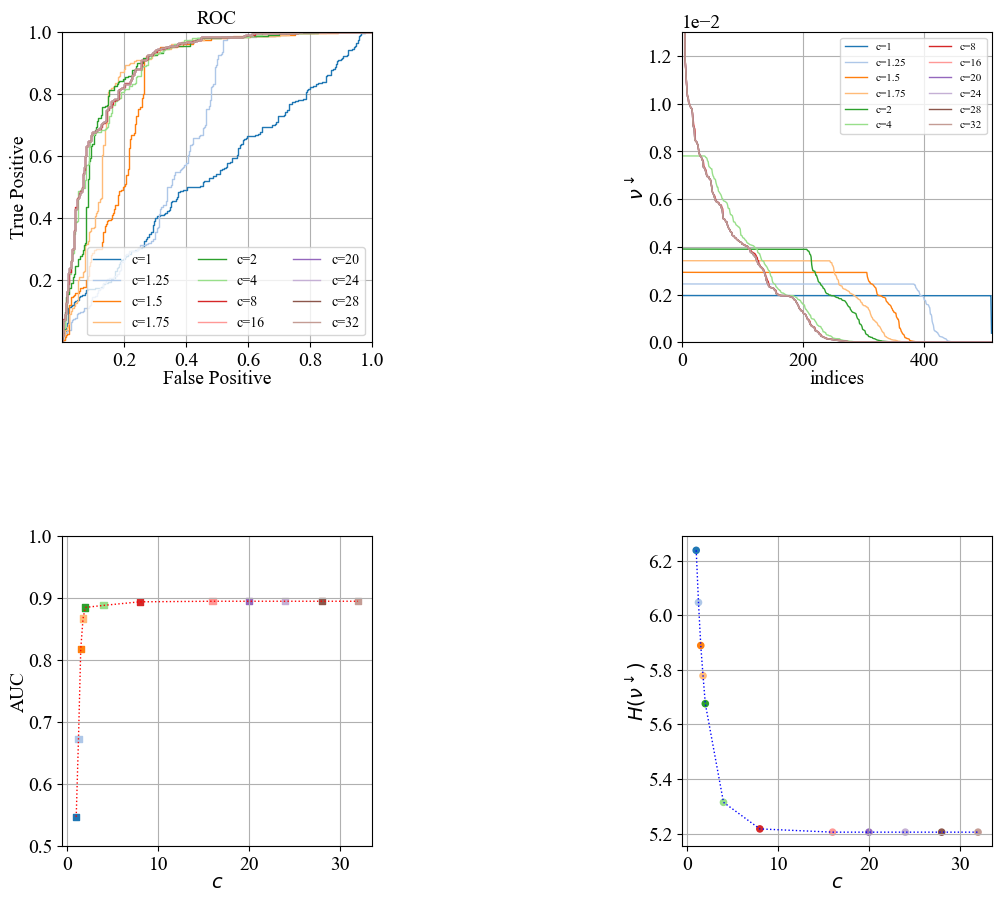

In [19]:
from matplotlib import cm
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
font = {'family': 'Times New Roman',
        'size': 14}
mpl.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
aucs = []
colors0 = mpl.cm.tab20(range(20))
fig.subplots_adjust(wspace=1.0, hspace=0.2)
entropies = []

for i in range(len(cs)):
    sorted_idx_lst = y_idx_sorted_lst_c[i]
    nu_sorted = np.array(nu_idx_sorted_lst_c[i])
    annot_Y_sorted = np.array(annot_Y_sorted_lst_c[i])
    fpr, tpr, _ = roc_curve(annot_Y_sorted, nu_sorted, pos_label=1)
    aucs.append(roc_auc_score(annot_Y_sorted, nu_sorted))
    axs[0, 0].plot(fpr, tpr, linewidth=1, label="c="+str(cs[i]), color=colors0[i])
    axs[0,0].set_box_aspect(1)
    entropies.append(-np.sum(np.log(nu_sorted**nu_sorted)))
    axs[0, 1].plot(list(range(0, nu_sorted.size)), nu_sorted, linewidth=1, label="c="+str(cs[i]), color=colors0[i])
    # axs[0, 1].semilogy(list(range(0, nu_sorted.size)), nu_sorted, linewidth=1, label="c="+str(cs[i]), color=colors0[i])
    axs[0,1].set_xlabel("indices", labelpad=0.01, **font)
    axs[0,1].set_xlim([0, nu_sorted.size])
    axs[0,1].set_box_aspect(1)
axs[0,0].set_xlabel("False Positive", labelpad=0.01, **font)
axs[0,0].set_xlim([0, 1])
axs[0,0].set_ylim([0, 1])
axs[0,0].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0], font = {'family': 'Times New Roman','weight': 'normal', 'size': 8})
axs[0, 0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0], font={'family': 'Times New Roman', 'weight': 'normal', 'size': 10})
axs[0,0].grid(True)
axs[0,0].set_ylabel("True Positive",labelpad=0.01, **font)
axs[0,0].set_title("ROC", **font)
axs[0,0].legend(prop={'family': 'Times New Roman', 'weight': 'normal', 'size': 10}, ncol=3)
axs[0,0].set_box_aspect(1)
axs[0,1].set_xlabel("indices", labelpad=0.02, **font)
axs[0,1].set_xlim([0, nu_sorted.size])
axs[0,1].set_ylim([0, 0.013])
axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# axs[0,1].set_ylim([1e-8, 1e-1])

axs[0, 1].legend(prop={'family': 'Times New Roman','weight': 'normal', 'size': 8}, ncol=2)

axs[0,1].grid(True)
axs[0,1].set_ylabel("$\\nu^{\downarrow}$", labelpad=0.01, **font)
axs[0,1].set_box_aspect(1)

axs[1,0].plot(cs, aucs, linewidth=1, color = "r", linestyle='dotted' )
axs[1, 0].scatter(cs, aucs, marker="s", s=20, c=colors0[0:len(cs)])

axs[1,1].plot(cs, entropies, linewidth=1, color = "b", linestyle='dotted' )
axs[1,1].scatter(cs, entropies, marker = "o", s=20, c=colors0[0:len(cs)])

axs[1,0].set_xlabel("$c$", labelpad=0.02, **font)
axs[1,0].set_ylabel("AUC", labelpad=0.02, **font)
axs[1,1].set_ylabel("$H(\\nu^{\downarrow})$", labelpad=0.01, **font)
axs[1,1].set_xlabel("$c$", labelpad=0.02, **font)
axs[1,0].set_ylim([0.5,1])
axs[1,0].grid(True)
axs[1,1].grid(True)
axs[1,0].set_box_aspect(1)
axs[1,1].set_box_aspect(1)


file_name7 = "EMNIST" + "_f_ipot_Fixed_Target_ROC"+".pdf"
file_name8 = "EMNIST" + "_f_ipot_Fixed_Target_ROC"+".svg"
file_name9 = "EMNIST" + "_f_ipot_Fixed_Target_ROC"+".png"

fig.savefig(file_name7, dpi=500, bbox_inches='tight', format='pdf')
fig.savefig(file_name8, dpi=500, bbox_inches='tight', format='svg')
fig.savefig(file_name9, dpi=500, bbox_inches='tight', format='png')
